# 3 Use-Cases for Gaussian Mixture Models (GMM)

In [266]:
# for tasks
import pandas as pd
import numpy as np
from scipy.io import loadmat
from sklearn.mixture import GaussianMixture

# auxiliary analysis and evaluation
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score

# for visualizations
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fast')
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["xaxis.labellocation"] = "right"
plt.rcParams["yaxis.labellocation"] = "top"
colors = ['#274E7A', '#5C8473', '#645A7E', '#24242E', '#DE4F1F']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors) 


## 1. Feature Engineering

Let's take a look at a dataset of books scraped from a fictional bookstore http://books.toscrape.com/.  
This dataset has several columns pertaining to bookstore book metadata, including a book title, category, star rating, price, whether the book is in stock, and quantity of books. 

I am most interested in taking a look at the quantity of books column as it has bimodal distribution. 

The goal here is to use GMM in order to generate two normally distributed features from the bimodal Quantity column.

In [77]:
# https://www.kaggle.com/datasets/sbonelondhlazi/bookstore-dataset

!kaggle datasets download -d sbonelondhlazi/bookstore-dataset
!unzip bookstore-dataset

# load dataset
df = pd.read_csv('books_scraped.csv')

# create a GMM model with 2 components (one for each mode in our distribution)
gmm = GaussianMixture(n_components=2)
gmm.fit(df[['Quantity']])

# predict component for the feature
df['component'] = gmm.predict(df[['Quantity']])


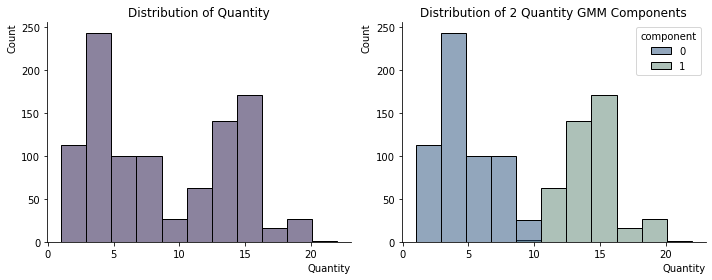

In [80]:
fig, (before, after) = plt.subplots(ncols=2, figsize=(10, 4))

# plot histogram for a feature of interest: Qunatity of books
sns.histplot(data=df, x='Quantity', ax=before, color=colors[2])
sns.despine()
before.title.set_text("Distribution of Quantity")

# plot histogram, showing two components
sns.histplot(data=df, x='Quantity', hue='component', ax=after)
sns.despine()
after.title.set_text("Distribution of 2 Quantity GMM Components")

plt.tight_layout()
plt.show()

## 2. Unsupervised Classification

In [124]:
# https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data

!kaggle datasets download -d parulpandey/palmer-archipelago-antarctica-penguin-data
!unzip palmer-archipelago-antarctica-penguin-data

# load the dataset
df = pd.read_csv('penguins_size.csv')

# remove null values
df = df[~df.isnull().any(axis=1)]
df = df.reset_index(drop=True)

# select features
features = ['culmen_length_mm', 'culmen_depth_mm']

# create a model with 3 components 
gmm = GaussianMixture(n_components=3)
gmm.fit(df[features])

# predict components and probabilities
components = gmm.predict(df[features])
probabilities = gmm.predict_proba(df[features])


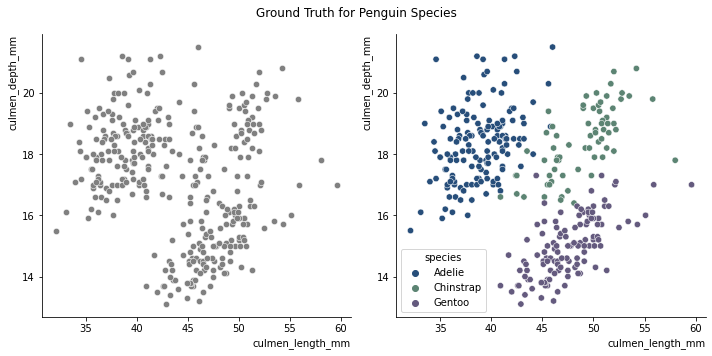

In [142]:
# plot a scatterplot of culment length vs. depth and colorcode species
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(data=df, x='culmen_length_mm', y='culmen_depth_mm', color='gray', s=40, ax=axes[0])
sns.scatterplot(data=df, x='culmen_length_mm', y='culmen_depth_mm', hue='species', s=40, ax=axes[1])
sns.despine()
plt.suptitle('Ground Truth for Penguin Species')
plt.tight_layout()
plt.show()

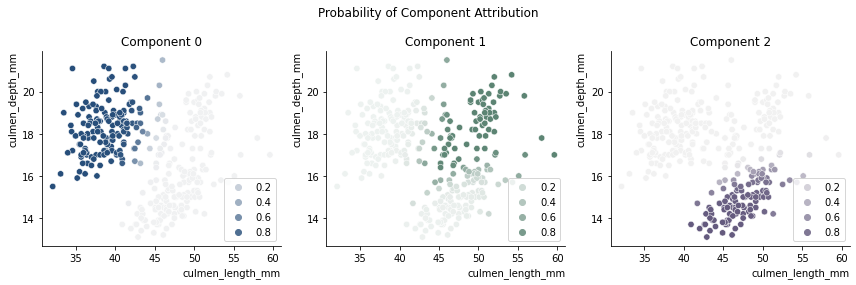

In [137]:
fix, axes = plt.subplots(ncols=3, figsize=(12, 4))

for i in range(3):

    proba_component_i = gmm.predict_proba(df[features])[:, i]
    category_color = sns.color_palette('light:%s' % colors[i], as_cmap=True)
    sns.scatterplot(data=df, x='culmen_length_mm', y='culmen_depth_mm', s=40,
                    hue=proba_component_i, palette=category_color, legend='brief', 
                    ax=axes[i])
    axes[i].set_title('Component %d' % i)
    sns.despine()
    
plt.suptitle('Probability of Component Attribution')
plt.tight_layout()
plt.show()

## 3. Anomaly Detection

In [177]:
# upload the datafile 
# http://odds.cs.stonybrook.edu/wine-dataset/
# Saket Sathe and Charu C. Aggarwal. LODES: Local Density meets Spectral Outlier Detection. SIAM Conference on Data Mining, 2016.
wine = loadmat('wine.mat')

# grab the features and create a dataframe
columns = ["alcohol", "malicacid", "ash", "alcalinity_of_ash", "magnesium",
          "total_phenols", "flavanoids", "nonflanoid_phenols", "proanthocyanins",
          "color_intensity", "hue", "0D280_0D315_of_diluted_wines", "proline"]

print('Total features:', len(columns))

df = pd.DataFrame(wine["X"], columns=columns)

# anomaly targets
y_true = wine["y"].flatten()

# fit the model with 2 components
gmm = GaussianMixture(n_components=2)
gmm.fit(df)

# get predicted data
component = gmm.predict(df)
proba = gmm.predict_proba(df)

Total features: 13


Explained variance ratio: [0.99624189 0.00338762]


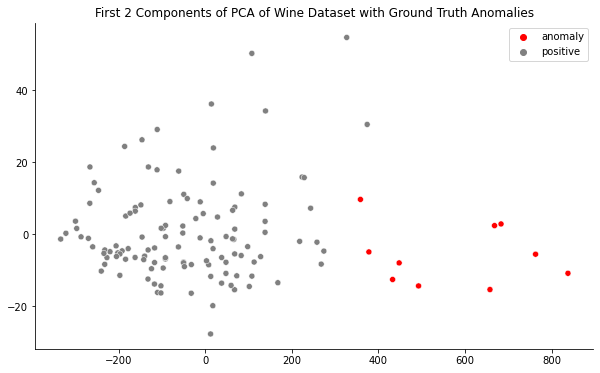

In [178]:
# create PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df)
print('Explained variance ratio:', pca.explained_variance_ratio_)

# show as scatterplot
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], 
                hue=np.where(y_true==1, 'anomaly', 'positive'), 
                palette=sns.color_palette(['r', 'gray'], as_cmap=True))
sns.despine()
plt.title('First 2 Components of PCA of Wine Dataset with Ground Truth Anomalies')
plt.show()

In [322]:
# in ground truth, 1 is anomaly
# gmm randomizes component index so we should align our ground truth with predicted values
# if predicted component 1 is positive, switch 1 and 0 components to align with 1 being anomaly
if sum(component) >= len(component)/2:
    component = -1*(component-1)
    proba = proba[:,[1,0]]
    

# put together confusion matrix
cm = pd.DataFrame(confusion_matrix(y_true, component), 
                  columns=['Predicted Positive', 'Predicted Anomaly'], 
                  index=['True Positive', 'True Anomaly'])

print(tabulate(cm, headers='keys', tablefmt='fancy_grid'))

╒═══════════════╤══════════════════════╤═════════════════════╕
│               │   Predicted Positive │   Predicted Anomaly │
╞═══════════════╪══════════════════════╪═════════════════════╡
│ True Positive │                  108 │                  11 │
├───────────────┼──────────────────────┼─────────────────────┤
│ True Anomaly  │                    0 │                  10 │
╘═══════════════╧══════════════════════╧═════════════════════╛


In [323]:
print('F1 Score:', f1_score(y_true, component))

F1 Score: 0.6451612903225806


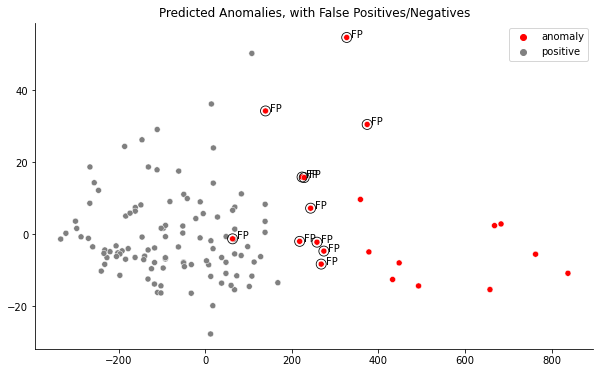

In [324]:
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], 
                hue=np.where(component==1, 'anomaly', 'positive'),
                palette=sns.color_palette(['red', 'gray'], as_cmap=True))

# plot and annotate false positives
pca_components_FP = pca_components[(y_true==0)&(component==1), :]
sns.scatterplot(x=pca_components_FP[:, 0], y=pca_components_FP[:, 1], color='black', fc='none', ec='black', s=100)

for i in range(len(pca_components_FP)):
    plt.annotate("FP", (pca_components_FP[-(i+1), 0]+10, pca_components_FP[-(i+1), 1]))

# plot and annotate false negatives
pca_components_FN = pca_components[(y_true==1)&(component==0), :]
sns.scatterplot(x=pca_components_FN[:, 0], y=pca_components_FN[:, 1], color='black')

for i in range(len(pca_components_FN)):
    plt.annotate("FP", (pca_components_FN[-(i+1), 0]+10, pca_components_FN[-(i+1), 1]))

sns.despine()
plt.title('Predicted Anomalies, with False Positives/Negatives')
plt.show()

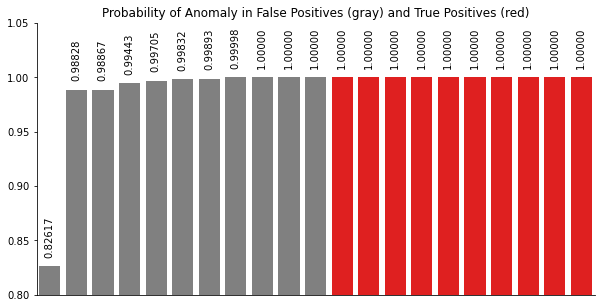

In [340]:
plt.figure(figsize=(10, 5))

proba_FP = proba[(y_true==0)&(component==1), 1]
proba_FP.sort()
proba_TP = proba[(y_true==1)&(component==1), 1]
proba_TP.sort()
proba_analysis = np.concatenate([proba_FP, proba_TP])
type = ['fp'] * len(proba_FP) + ['tp'] * len(proba_TP)
x = list(range(len(proba_analysis)))

ax = sns.barplot(x=x, y=proba_analysis, dodge=False, 
                 hue=type, palette=sns.color_palette(['gray', 'red'], as_cmap=True))

for i, val in enumerate(list(proba_analysis)):
    plt.annotate('%.5f' % val, (i-0.2, val+0.01), rotation=90)

ax.set_ybound(0.8, 1.05)
plt.xticks([])
sns.despine()
plt.title('Probability of Anomaly in False Positives (gray) and True Positives (red)')
plt.legend().remove()
plt.show()

In [243]:
# create new components based on the probability analysis
component_fixed = np.where(proba[:, 1]>0.99999, 1, 0)

In [244]:
# put together confusion matrix
cm = pd.DataFrame(confusion_matrix(y_true, component_fixed), 
                  columns=['Predicted Positive', 'Predicted Anomaly'], 
                  index=['True Positive', 'True Anomaly'])

print(tabulate(cm, headers='keys', tablefmt='fancy_grid'))

╒═══════════════╤══════════════════════╤═════════════════════╕
│               │   Predicted Positive │   Predicted Anomaly │
╞═══════════════╪══════════════════════╪═════════════════════╡
│ True Positive │                  116 │                   3 │
├───────────────┼──────────────────────┼─────────────────────┤
│ True Anomaly  │                    0 │                  10 │
╘═══════════════╧══════════════════════╧═════════════════════╛


In [271]:
print('F1 Score:', f1_score(y_true, component_fixed))

F1 Score: 0.8695652173913044


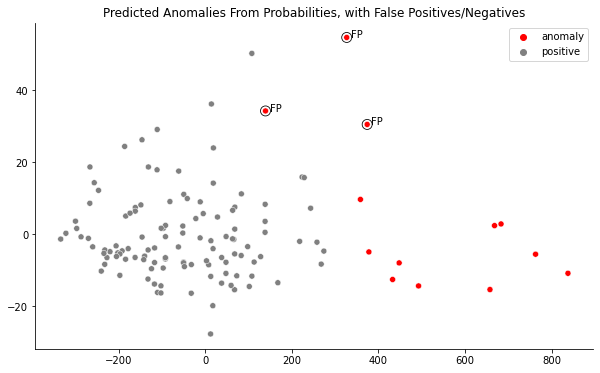

In [337]:
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], 
                hue=np.where(component_fixed==1, 'anomaly', 'positive'),
                palette=sns.color_palette(['red', 'gray'], as_cmap=True))

# plot and annotate false positives
pca_components_FP = pca_components[(y_true==0)&(component_fixed==1), :]
sns.scatterplot(x=pca_components_FP[:, 0], y=pca_components_FP[:, 1], color='black', fc='none', ec='black', s=100)

for i in range(len(pca_components_FP)):
    plt.annotate("FP", (pca_components_FP[-(i+1), 0]+10, pca_components_FP[-(i+1), 1]))

# plot and annotate false negatives
pca_components_FN = pca_components[(y_true==1)&(component_fixed==0), :]
sns.scatterplot(x=pca_components_FN[:, 0], y=pca_components_FN[:, 1], color='black')

for i in range(len(pca_components_FN)):
    plt.annotate("FP", (pca_components_FN[-(i+1), 0]+10, pca_components_FN[-(i+1), 1]))

sns.despine()
plt.title('Predicted Anomalies From Probabilities, with False Positives/Negatives')
plt.show()